In [1]:
from rascal.calibrator import Calibrator
from rascal.util import load_calibration_lines

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import json

from scipy.signal import find_peaks

C:\Users\Josh\AppData\Local\conda\conda\envs\astro\lib\site-packages\rascal\calibrator.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import pkg_resources
import pypeit

In this example, we'll calibrate a spectrum from the DEep Imaging Multi-Object Spectrograph (DEIMOS) instrument on Keck. We load an example calibration spectrum from the `pypeit` library:

In [3]:
data_path = pkg_resources.resource_filename("pypeit", "data/arc_lines/reid_arxiv/keck_deimos_830G.fits")

In [4]:
spectrum = fits.open(data_path)[1].data

This spectrum is from the 830G grating and contains Ne, Ar, Kr arc lines.

In [5]:
from scipy.signal import resample

In [6]:
resampled_flux = resample(spectrum['flux']-spectrum['flux'].min(), len(spectrum['flux'])*4)

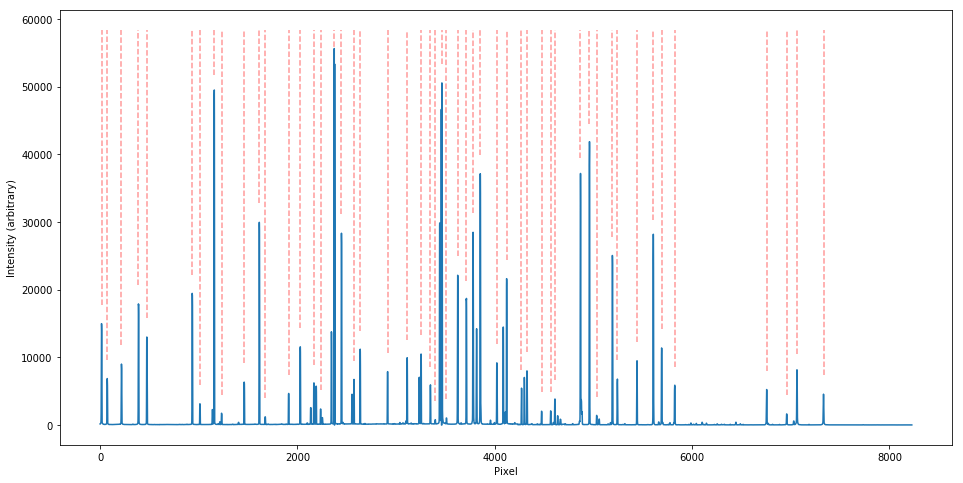

In [7]:
peaks, _ = find_peaks(resampled_flux, prominence=1000, distance=150)

peaks = peaks / 4.0

intensity_range = max(spectrum['flux']) - min(spectrum['flux'])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot("110")
ax.plot(spectrum['flux'])
ax.vlines(peaks,
          spectrum['flux'][peaks.astype('int')]+0.05*intensity_range,
          max(spectrum['flux'])+0.05*intensity_range,
          linestyle='dashed',
          alpha=0.4,
          color='red')
plt.xlabel("Pixel")
plt.ylabel("Intensity (arbitrary)")
plt.show()

As this is a reference template, it also has the wavelengths per pixel which we can use to check our calibration solution.

In [8]:
spectrum['wave']

array([ 6501.7978497 ,  6502.25466559,  6502.7114885 , ...,
       10332.98391368, 10333.43598629, 10333.8880502 ])

We'll use this as a hint for the spectral range of the instrument (setting the min/max range). To present a more fair scenario, we pick an approximate min/max and set a tolerance of 500A.

As usual we tell rascal the number of pixels on the detector, a fit tolerance appropriate to the instrument (in this case, we set a slightly lower fit tolerance.

In [34]:
c = Calibrator(peaks, elements = ["Ne", "Ar", "Kr"],
                      min_wavelength=6500,
                      max_wavelength=10300)

c.set_fit_constraints(n_pix=len(spectrum), range_tolerance=200, fit_tolerance=10, polydeg=6)

best_p = c.fit(max_tries=5000)

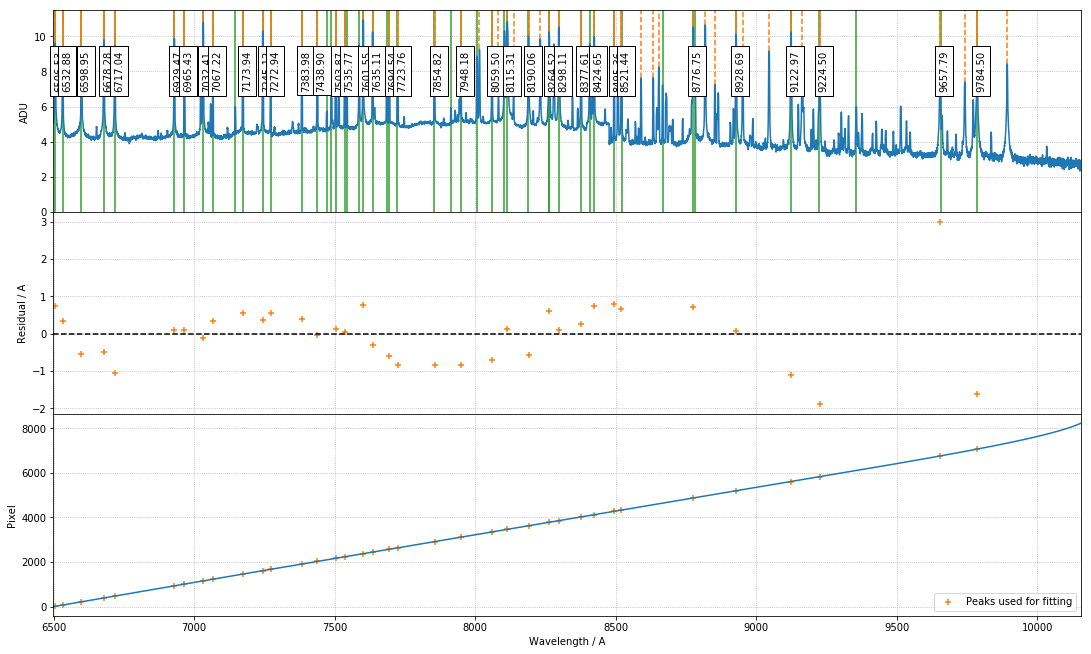

In [39]:
#best_p, x_fit, y_fit = c.match_peaks_to_atlas(best_p, polydeg=6, tolerance=5)
c.plot_fit(spectrum['flux'], best_p, plot_atlas=True)

Since we have an existing calibration, we can plot the fit residuals too:

In [36]:
x = c.polyval(best_p, np.arange(len(spectrum)))

In this case, pretty good - some of this error is likely due to peak mismatches. This could be improved using a more appropriate model. The bump is possibly the CCD gap

Text(0.5, 0, 'Pixel')

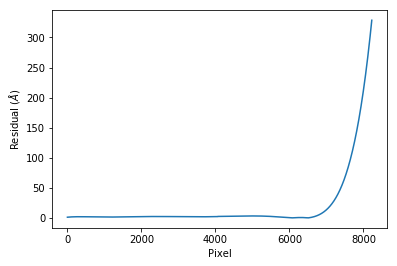

In [37]:
plt.plot(np.sqrt((x-spectrum['wave'])**2))
plt.ylabel("Residual ($\AA$)")
plt.xlabel("Pixel")

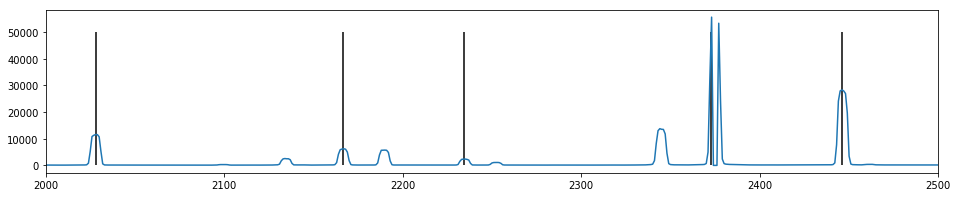

In [33]:
plt.figure(figsize=(16,3))
plt.plot(spectrum['flux'])
plt.xlim(2000,2500)
plt.vlines(peaks,0,50000)

In [16]:
def spectral_slice(spectrum):
    
    spectrum = np.array(spectrum).astype('float32')
    mask = spectrum > 0

    e_n = np.log(spectrum[mask]**2)
    err_thresh = 1.05/np.median(e_n)
    s_win = 10
    avg_spec = np.mean(e_n)
    avg_spec_2 = avg_spec**2
    
    n_pix = len(spectrum)
    lines = set()
    successive_time = 0
    
    while successive_time < 3 or s_win <= 30:
        
        prev_lines = set(lines)
        
        for i in range(n_pix-s_win):
            win_start = i
            win_end = i+s_win
            
            window = e_n[win_start:win_end]
            avg_win = window.mean()
            
            if avg_win/avg_spec_2 > err_thresh:
                if (win_start, win_end) not in lines:
                    lines.add((win_start, win_end))
            
        s_win += 1
        
        if len(prev_lines.difference(lines)) == 0:
            successive_time += 1
    
    return lines

In [17]:
lines = spectral_slice(spectrum['flux'])

In [18]:
locs = list(lines)

In [19]:
import random
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [20]:
def gauss(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

0.00031664481812432614
0.04818268168894913
fail
fail
0.004660781513288829
0.0006733237842550437
0.0007513066497659332
fail
fail
fail


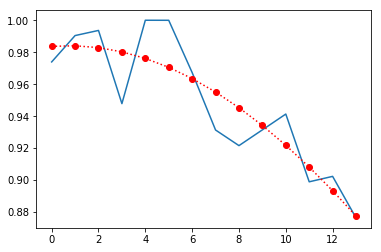

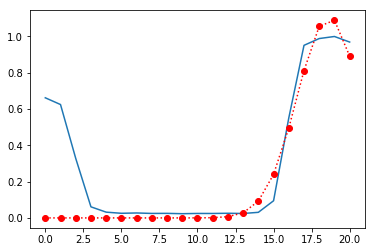

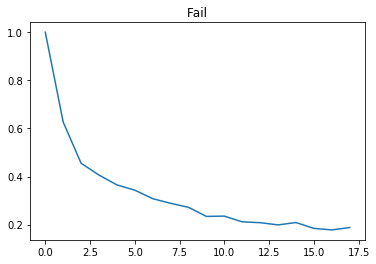

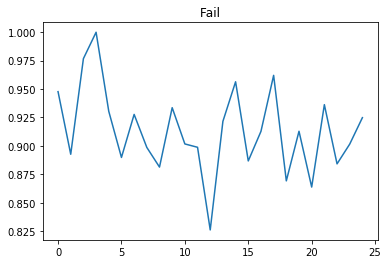

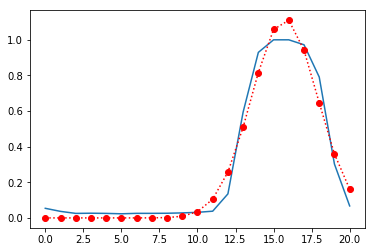

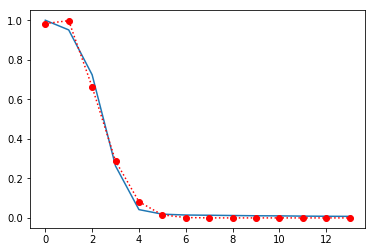

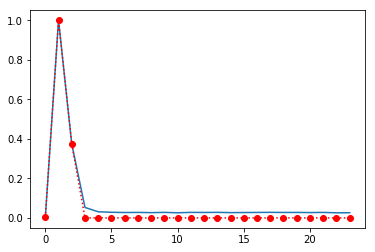

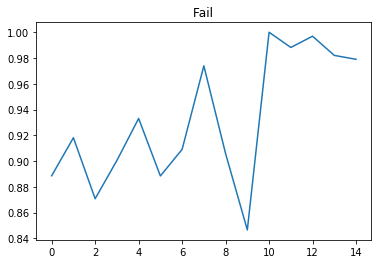

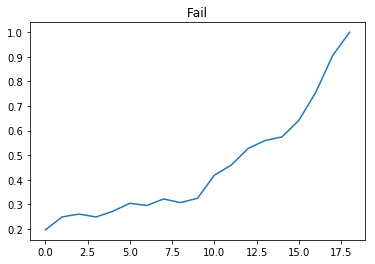

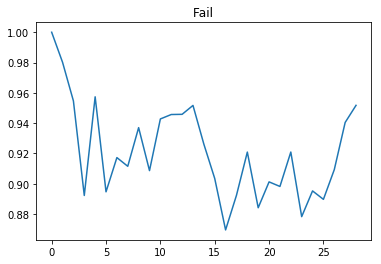

In [21]:
for i in range(10):
    loc = random.choice(locs)
    
    y = spectrum['flux'][loc[0]:loc[1]]
    y /= y.max()
    
    x = np.arange(len(y))
    
    n = len(x)                          #the number of data
    mean = sum(x*y)/n                   #note this correction
    sigma = sum(y*(x-mean)**2)/n        #note this correction
    
    try:
        popt,pcov = curve_fit(gauss,x,y,p0=[1,mean,sigma])

        plt.figure()
        plt.plot(x, y)
        plt.plot(x,gauss(x,*popt),'ro:',label='fit')
        
        err = np.mean((y - gauss(x,*popt))**2)
        print(err)
        
    except:
        plt.figure()
        plt.plot(x, y)
        print("fail")
        plt.title("Fail")

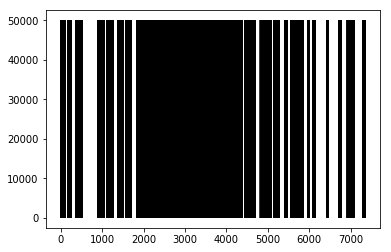

In [22]:
plt.plot()
plt.vlines(locs, 0, 50000)